In [2]:
# Face Detection Model
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import albumentations as alb
import tensorflow as tf
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## Collecting Data and Labelling 

In [14]:
images_path = 'data/images_path'
no_images = 30

## Setting up Camera

In [4]:
"""#Connecting to our camera
cap = cv2.VideoCapture(0)
for imgnum in range(no_images):
    print(f'Collecting image number {imgnum}') #Printing the image number
    ret, frame = cap.read() #Reading the frame
    imgname = os.path.join(images_path, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()"""

"#Connecting to our camera\ncap = cv2.VideoCapture(0)\nfor imgnum in range(no_images):\n    print(f'Collecting image number {imgnum}') #Printing the image number\n    ret, frame = cap.read() #Reading the frame\n    imgname = os.path.join(images_path, f'{str(uuid.uuid1())}.jpg')\n    cv2.imwrite(imgname, frame)\n    cv2.imshow('frame', frame)\n    time.sleep(0.5)\n    \n    if cv2.waitKey(1) & 0xFF == ord('q'):\n        break\ncap.release()\ncv2.destroyAllWindows()"

In [5]:
"!labelme" # Running the labelme command to annotate the images

'!labelme'

## Review Dataset and Build an Image Loading Function

In [17]:
images = tf.data.Dataset.list_files('data/images/*.jpg')
images.as_numpy_iterator().next()
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img
images = images.map(load_image)
images.as_numpy_iterator().next()
type(images)



InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpg'

### View Images in Matplotlib

In [7]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

NameError: name 'images' is not defined

## Partitioning Unaugmented Data 

We want 70% in the training set , 15% in both the test and validation set


In [8]:
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

# Set the paths for your directories
source_dir = 'data/images'
train_dir = 'data/train/images'
val_dir = 'data/val/images'
test_dir = 'data/test/images'

# Create directories if they don't exist
Path(train_dir).mkdir(parents=True, exist_ok=True)
Path(val_dir).mkdir(parents=True, exist_ok=True)
Path(test_dir).mkdir(parents=True, exist_ok=True)

# Get all file names in the source directory
file_names = os.listdir(source_dir)

# Split the file names into training and temp sets (70% training, 30% temp)
train_files, temp_files = train_test_split(file_names, test_size=0.3, random_state=42)

# Further split the temp set into validation and test sets (50% validation, 50% test of the temp set)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Function to move files
def move_files(file_list, dest_dir):
    for file_name in file_list:
        shutil.move(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

# Move the files
move_files(train_files, train_dir)
move_files(val_files, val_dir)
move_files(test_files, test_dir)

print(f"Moved {len(train_files)} files to {train_dir}")
print(f"Moved {len(val_files)} files to {val_dir}")
print(f"Moved {len(test_files)} files to {test_dir}")


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/images'

In [9]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

 ## Setup Albumentations Transform Pipeline


In [10]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### Test augmentation of photo

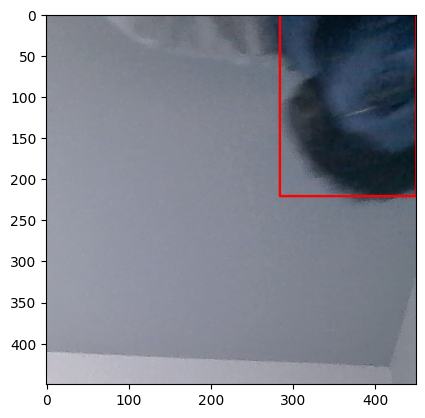

In [18]:
img = cv2.imread(os.path.join('data','train', 'images','1a585535-3658-11ef-8443-dc4628a0daab.jpg'))

with open(os.path.join('data', 'train', 'labels', '1a585535-3658-11ef-8443-dc4628a0daab.json'), 'r') as f:
    label = json.load(f)
    
    
coords = [point for pair in label['shapes'][0]['points'] for point in pair]


coords = list(np.divide(coords, [640,480,640,480]))
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

## Augmentation Pipeline 

In [20]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords = [point for pair in label['shapes'][0]['points'] for point in pair]

            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.16, 0.7833333333333333, -2.2204460492503132e-17, 0.2876846307385229, 'face'].
